In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw
import scipy.sparse as sparse

from tqdm import trange, tqdm

from collections import defaultdict, Counter
from itertools import combinations

import sys
sys.path.append('../')
from CAS import *

In [2]:
def read_snap(edge_file, com_file, prefix=""):
    edges = pd.read_csv(prefix+edge_file, sep='\t', comment="#")
    coms = []
    with open(prefix+com_file, "r") as infile:
        for line in infile:
            x = line[:-1]  # drop trailing newline
            x = x.split('\t')
            coms.append(frozenset([int(y) for y in x])) ## map to 0-based

    g = ig.Graph.DataFrame(edges, directed=False)

    c = [set() for _ in range(g.vcount())]
    for i, com in enumerate(coms):
        for v in com:
            c[v].add(i)
    c = [frozenset(i) for i in c] 
    g.vs["comms"] = c
    g.vs['n_comms'] = [len(x) for x in g.vs['comms']]
    # Vertex list is not continugous, drop degree 0 vertices
    g = g.subgraph(np.arange(g.vcount())[np.array(g.degree()) > 0])  

    # Drop some vars to free up memory
    del edges

    return g, g.vs["comms"]


def read_abcdoo(edge_file, com_file, prefix=""):
    ## read edges, build graph
    fn = prefix+edge_file
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = prefix+com_file
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            coms = [int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]  # map to 0-based
            try:
                coms.remove(0)  # Community 0 is outliers
            except ValueError:
                pass
            L.append(tuple(coms)) 
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G

In [3]:
## DBLP graph
dblp_g, dblp_coms = read_snap("com-dblp.ungraph.txt", "com-dblp.all.cmty.txt", "../../SNAP/")
abcdoo_d2_g = read_abcdoo("abcdoo_dblp_d2_edge.dat", "abcdoo_dblp_d2_com.dat", "../../ABCDGraphGenerator.jl/utils/")
abcdoo_d5_g = read_abcdoo("abcdoo_dblp_d5_edge.dat",  "abcdoo_dblp_d5_com.dat","../../ABCDGraphGenerator.jl/utils/")
abcdoo_d10_g = read_abcdoo("abcdoo_dblp_d10_edge.dat", "abcdoo_dblp_d10_com.dat", "../../ABCDGraphGenerator.jl/utils/")

print(f"DBLP has {dblp_g.vcount()} vertices.")
print(f"DBLP has {dblp_g.ecount()} edges.")

DBLP has 317080 vertices.
DBLP has 1049865 edges.


In [4]:
print("Get pairs of communities with large overlaps.")
def communities(comms):
    communities = defaultdict(set)
    for i, coms in enumerate(comms):
        for c in coms:
            communities[c].add(i)
    return list(communities.values())

def plot_overlap_densities(g, LARGE=50, graph_title="?"):
    large_overlaps = set()
    coms = communities(g.vs["comms"])
    for i in trange(len(coms)):
        for j in range(i):
            if len(coms[i].intersection(coms[j])) >= LARGE:
                large_overlaps.add((i,j))
    print(f"{len(large_overlaps)} pairs of communities have overlaps size >= {LARGE}")

    print("Compute densities.")
    densities = np.empty((len(large_overlaps), 4))
    for k, (i,j) in tqdm(enumerate(large_overlaps), total=len(large_overlaps)):
        I = coms[i].intersection(coms[j])
        sg = g.subgraph(I)
        idt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
        inter = sg.vcount()
        sg = g.subgraph(coms[i].union(coms[j]))
        udt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))
        sg = g.subgraph(np.random.choice(list(coms[i].union(coms[j])), size=inter))
        sdt = 2*sg.ecount()/(sg.vcount()*(sg.vcount()-1))

        densities[k, :] = [len(I),idt,udt,sdt]

    print("Plot Graph")
    _df = pd.DataFrame(densities, columns=['intersection','inter_density','union_density','sample_density'])
    ax = _df.boxplot(column=['inter_density','union_density','sample_density'], sym='.');
    ax.set_title(f"Large (>={LARGE}) Overlap Densities in {graph_title}")
    plt.show()

Get pairs of communities with large overlaps.


100%|██████████| 13477/13477 [00:25<00:00, 524.98it/s]


8913 pairs of communities have overlaps size >= 50
Compute densities.


100%|██████████| 8913/8913 [00:23<00:00, 372.60it/s]


Plot Graph


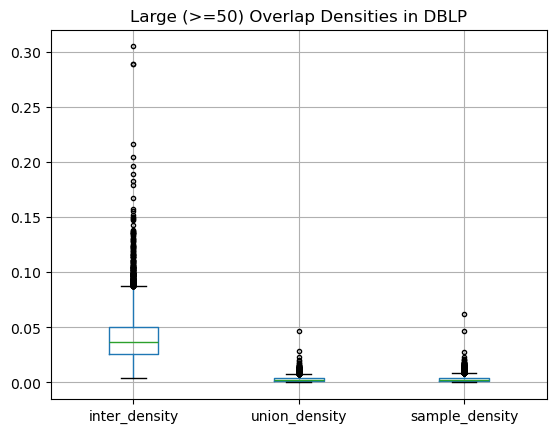

In [5]:
plot_overlap_densities(dblp_g, 50, "DBLP")

100%|██████████| 8287/8287 [00:16<00:00, 488.97it/s]


3022 pairs of communities have overlaps size >= 50
Compute densities.


100%|██████████| 3022/3022 [00:07<00:00, 380.83it/s]

Plot Graph


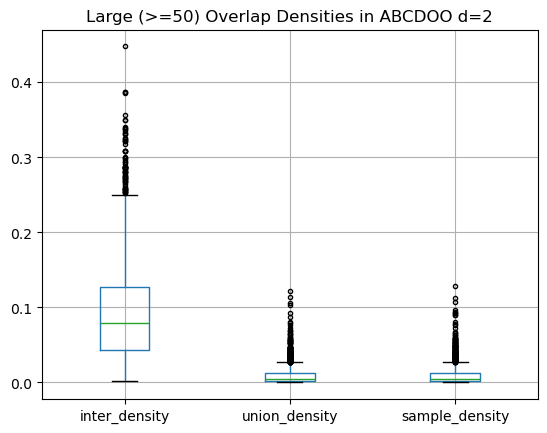

In [6]:
plot_overlap_densities(abcdoo_d2_g, 50, "ABCDOO d=2")

100%|██████████| 8031/8031 [00:16<00:00, 497.85it/s]


2446 pairs of communities have overlaps size >= 50
Compute densities.


100%|██████████| 2446/2446 [00:08<00:00, 294.14it/s]

Plot Graph


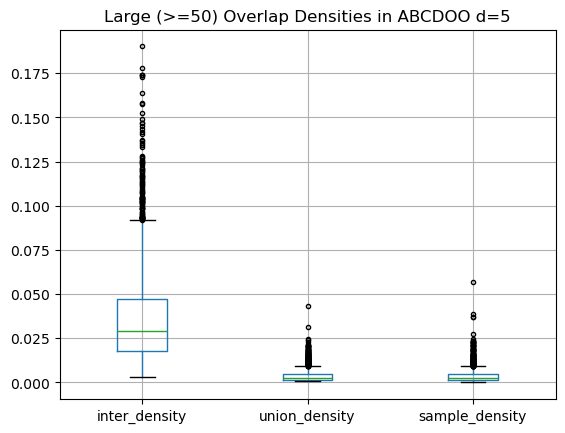

In [9]:
plot_overlap_densities(abcdoo_d5_g, 50, "ABCDOO d=5")

100%|██████████| 8190/8190 [00:17<00:00, 461.24it/s]


3164 pairs of communities have overlaps size >= 50
Compute densities.


100%|██████████| 3164/3164 [00:20<00:00, 156.32it/s]


Plot Graph


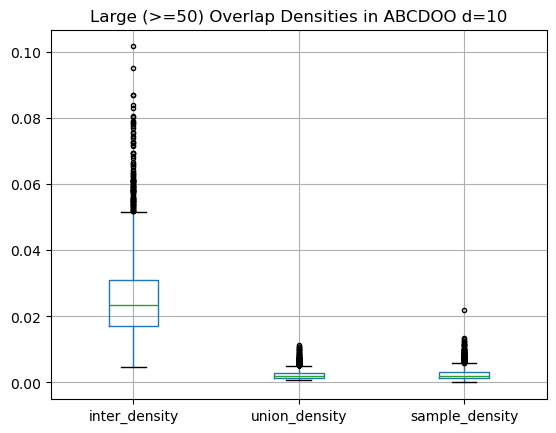

In [10]:
plot_overlap_densities(abcdoo_d10_g, 50, "ABCDOO d=10")